### Sources

[Introduction to Variational Inference](https://leimao.github.io/article/Introduction-to-Variational-Inference/) - Lei Mao, Sr. DL Engineer, NVIDIA, Santa Clara

[Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) - Blei et. al.

![Psuedo-code for coordinate ascent](../assets/VI_coord_ascent_gaussian_psuedo_code.png)

<p style="text-align: center;">Variational Inference for Gaussian Mixtures using Coordinate Ascent (Blei et. al.)</p>

In [4]:
#!pip install pomegranate

     |████████████████████████████████| 7.2 MB 736 kB/s eta 0:00:01


In [1]:
from pomegranate import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional, Union, Tuple

In [2]:
DF = pd.DataFrame
NP = np.ndarray

In [3]:


def EM_univariate_gaussian_optimizer():
    return

In [4]:
# Each entry in prior gaussians sets up a cluster center followed by the cluster standard deviation
prior_gaussians = [ 
    [-10,1],
    [0,1],
    [10,1]
]

dist_list = []

for k in prior_gaussians:
    dist_list.append(NormalDistribution(k[0],k[1]))

# Use GeneralMixtureModel in the pomegranate library to create a combined distribution
# from the individual Normal Distributions.
# The combined model is equivalent to a Gaussian Mixture model with as many Gaussaians as
# there are cluster centers
gaussian_mixture_model = GeneralMixtureModel(dist_list)

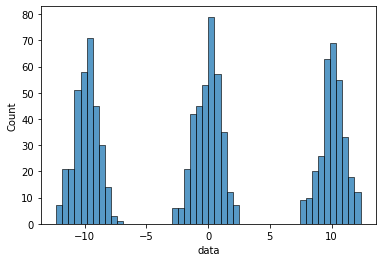

In [5]:
# Sample Data from the Gaussian Mixture model
data=pd.DataFrame(gaussian_mixture_model.sample(1000),columns=['data'])

# Visualize the distribution to make sure we are sampling data as expected
sns.histplot(data,x='data',bins=50)
plt.show()

![Psuedo-code for coordinate ascent](../assets/phi_update.png)

<p style="text-align: center;">Cluster assignment variational parameter update equation (Lei Mao)</p>

In [72]:
class univariate_gaussian_variational_inference(object):
    def __init__(self,data:NP,K:int)->None:
        
        if not isinstance(data, NP) or len(data.shape)>1:
            raise Exception("Input Data MUST be a 1 dimensional numpy array")
            
        self.data=data
        self.k=K
        self.num_samples=data.shape[0]
        self.cluster_assignments=None
        
    def init_variational_params(self)->Tuple[NP,NP,NP]:
        # Initialize Variational Parameters
        
        # For the m parameter, a reasonable initialization is 
        # finding the limits of the data and sampling from a 
        # uniform distribution within that range
        data_range = (min(self.data),max(self.data))
        m = np.random.uniform(low=data_range[0],high=data_range[1],size=self.k)
        
        # For the S variational param, leave all standard deviations as one
        var = np.ones(self.k).astype(float) ** 2 # adding the square just to make sure we know what this variable is later
        
        # For the phi latent variable
        # initialize an N x K matrix
        # then population the matrix with random probabilities
        # each row sums to 1
        phi = np.random.uniform(low=0,high=1,size=[len(data),self.k])
        phi = phi/phi.sum(axis=1,keepdims=True)
        
        return (m,var,phi)
        
    def coordinate_ascent_optimizer(self,num_iters:int=1000)->Tuple[NP,NP,NP]:
        m,var,phi = self.init_variational_params()
        
        # For the first implementation, we don't compute ELBO
        # We simply run the algorithm for N iterations
        for _ in range(num_iters):
            for i in range(len(self.data)):
                phi[i,:] = np.exp(m*self.data[i] - ((var + m**2)/2))
                phi[i,:] = phi[i,:] / phi[i,:].sum()
                
            # Now let us assume that the prior variance of component means is 1
            # then
            for k in range(self.k):
                m[k] = np.sum(phi[:,k] * self.data)/(1 + np.sum(phi[:,k] * self.data))
                var[k] = 1 / (1 + np.sum(phi[:,k] * self.data))
            
        self.cluster_assignments = np.argmax(phi,axis=1)
        
        return m,var,phi

In [73]:
vi=univariate_gaussian_variational_inference(data['data'].values,3)

In [74]:
vi.init_variational_params()

(array([-9.09426995,  5.90735413,  3.02960316]),
 array([1., 1., 1.]),
 array([[0.25251222, 0.31276896, 0.43471882],
        [0.19324437, 0.33913792, 0.46761772],
        [0.08051881, 0.49201937, 0.42746182],
        ...,
        [0.25857445, 0.27610858, 0.46531697],
        [0.2565877 , 0.33502179, 0.40839051],
        [0.4661485 , 0.0218673 , 0.5119842 ]]))

In [75]:
vi.coordinate_ascent_optimizer(1)

(array([1.00623641, 1.00033168, 0.99968301]),
 array([-0.00623641, -0.00033168,  0.00031699]),
 array([[2.18824770e-18, 1.18288501e-30, 1.00000000e+00],
        [5.68357729e-03, 9.94316421e-01, 2.20131748e-09],
        [4.60650458e-19, 9.73420282e-32, 1.00000000e+00],
        ...,
        [4.89686014e-04, 9.99510314e-01, 3.22037105e-12],
        [5.21184713e-03, 9.94788151e-01, 1.74696174e-09],
        [1.36209101e-07, 2.36341371e-13, 9.99999864e-01]]))

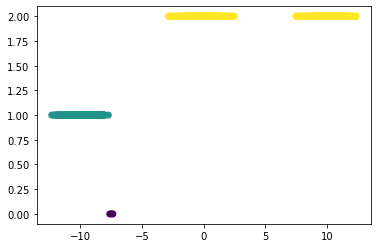

In [76]:
plt.scatter(data,vi.cluster_assignments,c=vi.cluster_assignments)
plt.show()

In [50]:
data.shape

(1000, 1)

In [56]:
vi.cluster_assignments

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,